- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2


- E02: I was not careful with the intialization of the network in this video. 

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 

(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?


- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [97]:
import torch
from torch import Tensor

In [3]:
#  load the names
names = open("../names.txt", "r").read().splitlines()
names[:3]

['emma', 'olivia', 'ava']

In [271]:
# count the number of letters and prepare the index
letters = set()
for name in names:
    for c in name:
        letters.add(c)

letter_list = list(letters)
letter_list.append(".")
letter_list.sort()

stoi = {s:i for i, s in enumerate(letter_list)}
itos = {i:s for s, i in stoi.items()}

In [272]:
# create the dataset
# the number of letters you take in as context should be the amount of padding you place at the start

# this will be the inputs
x = []

# this will be the outputs
y = []

# padding size
block_size = 3

for name in names:
    # add the necessary padding to the name
    modified_string = block_size * "." + name + "."
    for ch1, ch2, ch3, ch4 in zip(modified_string, modified_string[1:], modified_string[2:], modified_string[3:]):
        x.append([stoi[ch1], stoi[ch2], stoi[ch3]])
        y.append(stoi[ch4])

X = torch.tensor(x)
Y = torch.tensor(y)

print(X.shape)
print(Y.shape)

torch.Size([228146, 3])
torch.Size([228146])


In [273]:
# set a random seed for the generator
g = torch.Generator().manual_seed(2147483647)

# create an encoding format for the model
# start with a 27, 2 -> each character is represented by a 2 dimension vector
enc = torch.randn((27, 2), generator=g)

# create the first hidden layer for the network
# (number of inputs that should be taken, number of outputs that should be produced)

# this is the first layer
w1 = torch.randn((3*2, 100), generator=g)
b1 = torch.randn(100, generator=g)

# this is the output layer
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# store the params in a list to make life easier later
params = [enc, w1, b1, w2, b2]

print(sum([p.nelement() for p in params]))

# record gradient for all of the params, so backpropagation can work later
for p in params:
    p.requires_grad = True

3481


In [122]:
# note to self from video! Indexing can be done with tensors as well, so this is super convenient! :D
enc[X[:3]].shape

torch.Size([3, 3, 2])

In [117]:
# random_sample = torch.randint(0, X.shape[0], (3,), generator=g)
print(X[[1, 2, 3, 4]])
print(Y[[1, 2, 3]])

tensor([[ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
tensor([13, 13,  1])


Based on Mr Karpathy, when finding the optimal learning rate, you should look for (1) a LR for which the loss decreases slowly (2) a LR before the loss starts to become unstable, by going up and down a lot

(1) 0.001

(2) 1.0

In [197]:
# try to create values for the learning rate
exps = torch.linspace(-3, 0, 1000)
lrs = 10**exps

In [246]:
import torch.nn.functional as F

learning_rates = []
losses = []
sample_size = 32

# create a loop for training
for i in range(1000):
    # take a random sample from the dataset
    random_sample = torch.randint(0, X.shape[0], (sample_size,))
    input = enc[X[random_sample]].view(sample_size, -1)
    h1 = torch.tanh(input @ w1 + b1)

    # pass it to the second layer
    output = h1 @ w2 + b2

    # calculate the loss of the current NN
    loss = F.cross_entropy(output, Y[random_sample])

    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        p.data += -lrs[i] * p.grad

    losses.append(loss.item())
    # put a log10 here so that the values on the graph would be spaced out evenly
    learning_rates.append(lrs[i].log10().item())

print(loss.item())

7.405254364013672


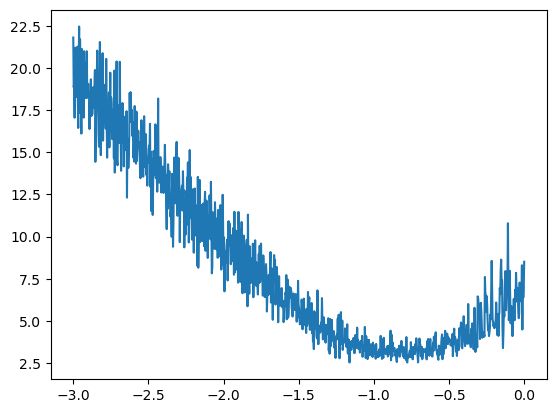

In [200]:
import matplotlib.pyplot as plt

plt.plot(learning_rates, losses)

plt.show()

From the plt above, I guess the ideal learning rate is indeed around 10**-1.0

In [292]:
# try training with the ideal LR
import torch.nn.functional as F

losses = []
training_round = []
sample_size = 32

# create a loop for training
for i in range(8000):
    # take a random sample from the dataset
    random_sample = torch.randint(0, X.shape[0], (sample_size,))
    input = enc[X[random_sample]].view(sample_size, -1)
    h1 = torch.tanh(input @ w1 + b1)

    # pass it to the second layer
    output = h1 @ w2 + b2

    # calculate the loss of the current NN
    loss = F.cross_entropy(output, Y[random_sample])

    losses.append(loss.log10().item())
    training_round.append(i)

    for p in params:
        p.grad = None

    loss.backward()

    # lr = 0.1 if i < 150000 else 0.01
    lr = 0.01
    for p in params:
        p.data += -lr * p.grad




print(loss.item())

2.3452248573303223


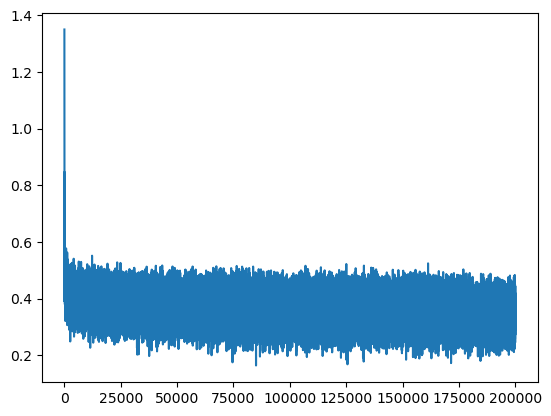

In [262]:
plt.plot(training_round, losses)
plt.show()

In [293]:
# calculate the final loss

h = torch.tanh(enc[X].view(X.shape[0], -1) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2310, grad_fn=<NllLossBackward0>)

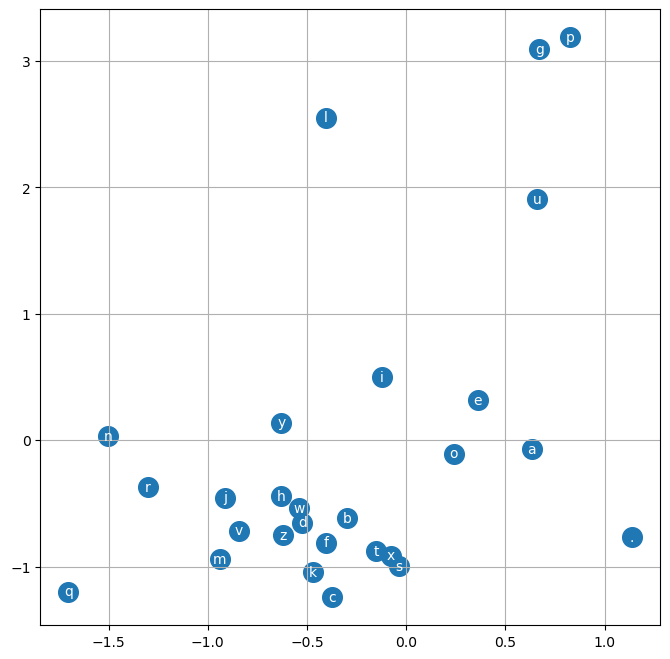

In [294]:
# plot out the encodings - code copied from Mr Karpathy

plt.figure(figsize=(8,8))
plt.scatter(enc[:,0].data, enc[:,1].data, s=200)
for i in range(enc.shape[0]):
    plt.text(enc[i,0].item(), enc[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')